# Epileptic Seizure Detection — Notebook

This notebook walks through a complete pipeline for building a seizure-detection model using the provided **Epileptic Seizure Recognition** dataset. Run cells in order. Comments and explanation are included in each cell.

In [130]:
# Imports & Setup
import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import joblib

SEED = 1337
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print('TensorFlow version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))
print('NumPy version:', np.__version__)
import matplotlib
print('Matplotlib version:', matplotlib.__version__)
print('Seaborn version:', sns.__version__)


TensorFlow version: 2.19.0
GPU available: []
NumPy version: 1.26.4
Matplotlib version: 3.9.2
Seaborn version: 0.13.2


In [131]:
# Load dataset and quick EDA
# csv_path = r'/mnt/data/Epileptic Seizure Recognition.csv'
csv_path = 'Epileptic Seizure Recognition.csv'
df = pd.read_csv(csv_path)
print('Loaded CSV with shape:', df.shape)
display(df.head())
label_col = df.columns[-1]
print('\nLabel column:', label_col)
print('\nValue counts for label:')
display(df[label_col].value_counts())

# Convert labels: 1 = Seizure, everything else = Non-seizure
df[label_col] = (df[label_col] == 1).astype(int)

print("\nBinary distribution (0=No Seizure, 1=Seizure):")
display(df[label_col].value_counts())



Loaded CSV with shape: (11500, 180)


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5



Label column: y

Value counts for label:


y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64


Binary distribution (0=No Seizure, 1=Seizure):


y
0    9200
1    2300
Name: count, dtype: int64

In [132]:
# Preprocessing - create binary target (seizure vs non-seizure)
label_col = df.columns[-1]
unique_labels = sorted(df[label_col].unique().tolist())
print('Unique labels in dataset:', unique_labels)

# Map smallest label (commonly 1) to seizure; others to non-seizure
df['binary_target'] = df[label_col].apply(lambda x: 1 if x == 1 else 0)
print('Binary target distribution:')
display(df['binary_target'].value_counts())

# Prepare features and targets
feature_cols = [c for c in df.columns if c not in [label_col, 'binary_target', 'Unnamed']]
X = df[feature_cols].values.astype('float32')
y = df['binary_target'].values.astype('int64')

# --- 1. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print('Train/test shapes:', X_train.shape, X_test.shape)
X_test_orig = X_test.copy() # Keep original raw features for predictions

# --- 2. Scale features BEFORE oversampling ---
# Fit the scaler ONLY on the original training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# Apply the same scaling to the test data
X_test = scaler.transform(X_test)
print("Features scaled successfully.")

# --- 3. Handle imbalance using a better method (SMOTE) ---
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=SEED)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After applying SMOTE:", np.bincount(y_train))

# --- 4. Reshape to (samples, timesteps, channels) for 1D-CNN/LSTM ---
timesteps = X_train.shape[1]
X_train = X_train.reshape((-1, timesteps, 1))
X_test = X_test.reshape((-1, timesteps, 1))
print('Reshaped for models:', X_train.shape, X_test.shape)

# --- Final distribution check ---
print("Train seizure distribution:", np.bincount(y_train))
print("Test seizure distribution:", np.bincount(y_test))

Unique labels in dataset: [0, 1]
Binary target distribution:


binary_target
0    9200
1    2300
Name: count, dtype: int64

Train/test shapes: (9200, 178) (2300, 178)
Features scaled successfully.
After applying SMOTE: [7360 7360]
Reshaped for models: (14720, 178, 1) (2300, 178, 1)
Train seizure distribution: [7360 7360]
Test seizure distribution: [1840  460]


In [133]:
def build_model(input_length, model_variant='bilstm', dropout=0.4, n_classes=2): # Increased dropout
    inp = layers.Input(shape=(input_length, 1))
    x = layers.Conv1D(64, kernel_size=7, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(dropout)(x)

    if model_variant == 'bilstm':
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # Reduced units
        x = layers.Dropout(dropout)(x)
        x = layers.Bidirectional(layers.LSTM(32))(x) # Reduced units
    else: # gru
        x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Bidirectional(layers.GRU(32))(x)

    x = layers.Dense(64, activation='relu')(x) # Reduced units
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [134]:
# # (In your training notebook)

# def build_model(input_length, model_variant='bilstm', dropout=0.3, n_classes=2):
#     inp = layers.Input(shape=(input_length, 1))
#     x = layers.Conv1D(64, kernel_size=7, padding='same', activation='relu')(inp)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling1D(2)(x) # Switched to MaxPooling for better feature extraction
#     x = layers.Dropout(dropout)(x)

#     x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling1D(2)(x)
#     x = layers.Dropout(dropout)(x)

#     if model_variant == 'bilstm':
#         x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
#         x = layers.Dropout(dropout)(x)
#         x = layers.Bidirectional(layers.LSTM(64))(x)
#     else: # gru
#         x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
#         x = layers.Dropout(dropout)(x)
#         x = layers.Bidirectional(layers.GRU(64))(x)

#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(dropout)(x)
#     out = layers.Dense(n_classes, activation='softmax')(x)

#     model = models.Model(inputs=inp, outputs=out)
#     # Compile the model here, once.
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(1e-3),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # Build and check
# model = build_model(X_train.shape[1], model_variant='bilstm')
# model.summary()

Epoch 1/30
196/196 - 21s - 109ms/step - accuracy: 0.9963 - loss: 0.0112 - val_accuracy: 0.9819 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 2/30
196/196 - 11s - 54ms/step - accuracy: 0.9948 - loss: 0.0138 - val_accuracy: 0.9787 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 3/30
196/196 - 11s - 57ms/step - accuracy: 0.9954 - loss: 0.0129 - val_accuracy: 0.9955 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 4/30
196/196 - 11s - 57ms/step - accuracy: 0.9975 - loss: 0.0077 - val_accuracy: 0.9855 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 5/30
196/196 - 10s - 53ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9891 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 6/30
196/196 - 13s - 67ms/step - accuracy: 0.9985 - loss: 0.0042 - val_accuracy: 0.9928 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 7/30
196/196 - 20s - 104ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9937 - val_loss: 0.0262 - learning_rate: 5.0000e-04
Epoch 8/30
196/196 - 16s - 81ms/ste

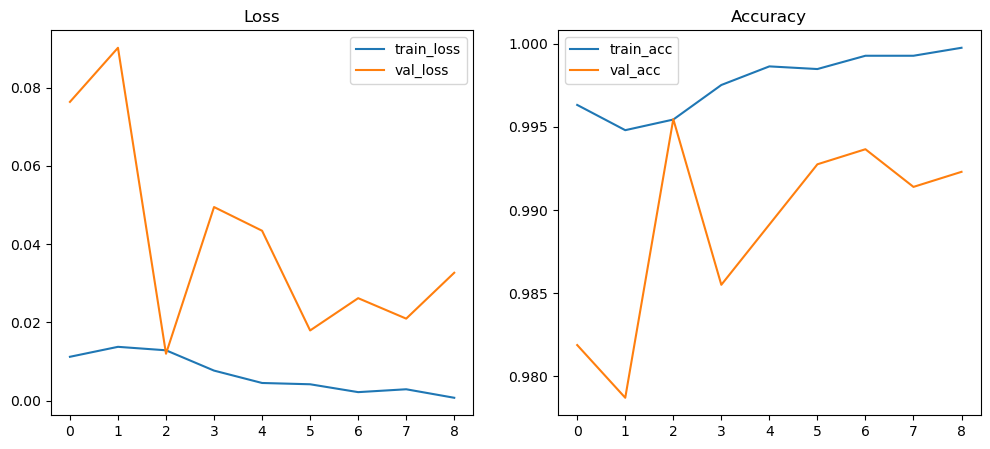

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9766    0.9882      1840
           1     0.9145    1.0000    0.9553       460

    accuracy                         0.9813      2300
   macro avg     0.9573    0.9883    0.9718      2300
weighted avg     0.9829    0.9813    0.9816      2300

ROC AUC Score: 0.9991381143667297


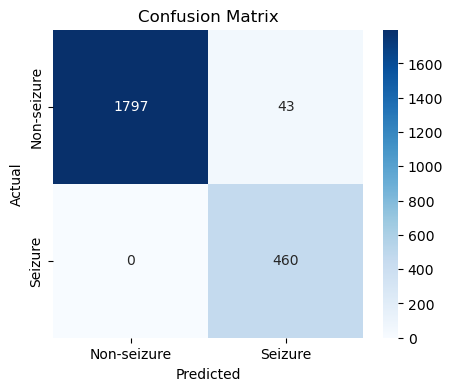

In [135]:
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns

# ----------------------------
# Training Parameters
# ----------------------------
EPOCHS = 30
BATCH_SIZE = 64

# ----------------------------
# Callbacks
# ----------------------------
cb = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# ----------------------------
# Compile model with only accuracy
# ----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# Train the model with class weights
# ----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #class_weight=class_weights,   # apply class weights
    callbacks=cb,
    verbose=2
)

# ----------------------------
# Plot training curves
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# ----------------------------
# Evaluate on test set
# ----------------------------
test_probs = model.predict(X_test)
test_preds = (test_probs[:,1] > 0.5).astype(int)  # seizure probability threshold 0.5

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, test_preds, digits=4))

# ROC AUC
roc_auc = roc_auc_score(y_test, test_probs[:,1])
print("ROC AUC Score:", roc_auc)

# Confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-seizure','Seizure'],
            yticklabels=['Non-seizure','Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
✅ Test Accuracy: 0.981304347826087
✅ Test AUC: 0.9991381143667297

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9766    0.9882      1840
           1     0.9145    1.0000    0.9553       460

    accuracy                         0.9813      2300
   macro avg     0.9573    0.9883    0.9718      2300
weighted avg     0.9829    0.9813    0.9816      2300



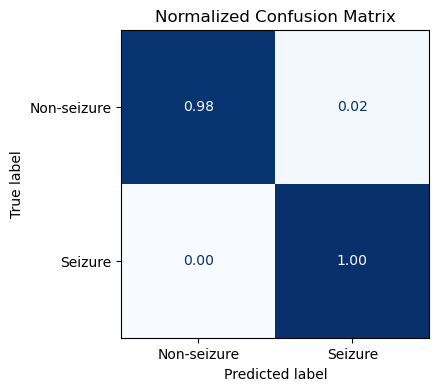

In [136]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ----------------------------
# Predictions on test set
# ----------------------------
test_probs = model.predict(X_test)
test_preds = (test_probs[:, 1] > 0.5).astype(int)  # Seizure threshold = 0.5

# ----------------------------
# Basic metrics
# ----------------------------
from sklearn.metrics import accuracy_score
print('✅ Test Accuracy:', accuracy_score(y_test, test_preds))
print('✅ Test AUC:', roc_auc_score(y_test, test_probs[:, 1]))

# ----------------------------
# Detailed classification report
# ----------------------------
print('\nClassification Report:')
print(classification_report(y_test, test_preds, digits=4))

# ----------------------------
# Confusion Matrix (normalized)
# ----------------------------
cm = confusion_matrix(y_test, test_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-seizure', 'Seizure'])

plt.figure(figsize=(5,4))
disp.plot(cmap='Blues', values_format=".2f", ax=plt.gca(), colorbar=False)
plt.title("Normalized Confusion Matrix")
plt.show()


In [137]:
import os
import joblib
import tensorflow as tf

# ----------------------------
# Folder path to save model & scaler
# ----------------------------
folder_path = r"D:\epileptic project"
os.makedirs(folder_path, exist_ok=True)  # Ensure folder exists

# ----------------------------
# Save the trained model
# ----------------------------
model_save_path = os.path.join(folder_path, "seizure_detection_model.keras")
model.save(model_save_path)  # .keras format
print("✅ Saved model to:", model_save_path)

# ----------------------------
# Save the scaler for future inference
# ----------------------------
scaler_save_path = os.path.join(folder_path, "scaler.save")
joblib.dump(scaler, scaler_save_path)
print("✅ Saved scaler to:", scaler_save_path)


✅ Saved model to: D:\epileptic project\seizure_detection_model.keras
✅ Saved scaler to: D:\epileptic project\scaler.save


In [138]:
# ===============================
# 🔮 Single Sample Inference
# ===============================

# Choose a test sample index
idx = 0  # Change this to any valid index (0, 1, 2, ...)

# Use original test features (before reshape)
sample_raw = X_test_orig[idx].reshape(1, -1)  # keep original 178 features

# Scale features using the saved scaler
sample_scaled = scaler.transform(sample_raw)

# Reshape for 1D-CNN/LSTM input
sample_reshaped = sample_scaled.reshape(1, timesteps, 1)

# Predict class probabilities
prob = model.predict(sample_reshaped, verbose=0)[0]

# Determine predicted class
predicted_class = 1 if prob[1] > 0.5 else 0

# Display results
print(f"✅ Probabilities: {prob}")
print(f"✅ Seizure Probability: {prob[1]:.6f}")
print(f"✅ Predicted class: {predicted_class} ({'Seizure' if predicted_class==1 else 'No Seizure'})")
print(f"✅ Actual class: {y_test[idx]} ({'Seizure' if y_test[idx]==1 else 'No Seizure'})")


✅ Probabilities: [9.999908e-01 9.225459e-06]
✅ Seizure Probability: 0.000009
✅ Predicted class: 0 (No Seizure)
✅ Actual class: 0 (No Seizure)


## Next steps

You can now:

- Export this notebook and run on a GPU instance for better accuracy (increase EPOCHS).
- Wrap model.predict into a FastAPI/Flask endpoint for real-time inference.
- Create a dashboard (Streamlit) to upload EEG and get predictions.

If you'd like, I can run this notebook here to train and show outputs, or simply provide the notebook file for you to run locally. What do you prefer?

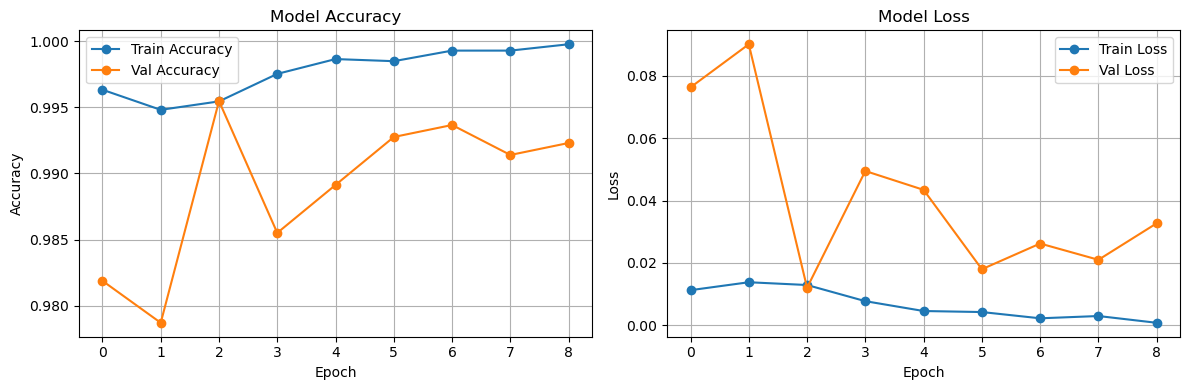

In [139]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call function
plot_training_history(history)


In [140]:
# =========================================
# 🔮 7. Inference: Predict on New EEG Data
# =========================================

def predict_seizure(person_features, threshold=0.2):
    """
    Predict seizure from a 1D EEG feature vector.

    Args:
        person_features (np.array): 1D array of EEG features (178,)
        threshold (float): Probability threshold to classify as seizure

    Returns:
        predicted_class (int): 1=Seizure, 0=No Seizure
        seizure_prob (float): Model-predicted probability of seizure
    """
    # Scale and reshape
    features_scaled = scaler.transform(person_features.reshape(1, -1))
    features_reshaped = features_scaled.reshape(1, timesteps, 1)
    
    # Predict
    prob = model.predict(features_reshaped, verbose=0)[0]
    predicted_class = 1 if prob[1] > threshold else 0
    
    return predicted_class, prob[1]


# ===============================
# 🧪 Example: Test on Sample
# ===============================

# Pick one seizure sample from the test set
sample_idx = np.where(y_test == 1)[0][0]  # first seizure sample
example_features = X_test_orig[sample_idx]  # original features (unscaled)
true_label = y_test[sample_idx]            # ground truth

predicted_label, seizure_prob = predict_seizure(example_features)

print(f"Testing on sample {sample_idx}:")
print(f"👉 Ground Truth: {'Seizure' if true_label==1 else 'No Seizure'}")
print(f"👉 Model Prediction: {'Seizure' if predicted_label==1 else 'No Seizure'}")
print(f"👉 Seizure Probability: {seizure_prob:.6f}")


Testing on sample 3:
👉 Ground Truth: Seizure
👉 Model Prediction: Seizure
👉 Seizure Probability: 1.000000


In [141]:
# =========================================
# 📊 9. Create a Results Table for Predictions
# =========================================

import pandas as pd

results = []

# Use original raw features from the test set
X_test_raw = X_test_orig  # already unscaled

for i in range(len(X_test_raw)):
    features = X_test_raw[i]  # 1D raw feature vector
    true_label = y_test[i]
    
    # Predict using our inference function
    pred_label, seizure_prob = predict_seizure(features)  # scales internally
    
    results.append({
        "Sample_ID": i,
        "Ground_Truth": "Seizure" if true_label==1 else "No Seizure",
        "Prediction": "Seizure" if pred_label==1 else "No Seizure",
        "Seizure_Prob": seizure_prob
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display first 20 rows
print("\n📌 Prediction Results on Test Data:")
display(results_df.head(20))



📌 Prediction Results on Test Data:


,Sample_ID,Ground_Truth,Prediction,Seizure_Prob
0,0,No Seizure,No Seizure,9.225459e-06
1,1,No Seizure,No Seizure,5.705198e-04
2,2,No Seizure,No Seizure,3.566680e-07
3,3,Seizure,Seizure,9.999995e-01
4,4,No Seizure,No Seizure,1.871900e-06
5,5,No Seizure,No Seizure,3.352235e-06
6,6,No Seizure,No Seizure,1.503659e-03
7,7,No Seizure,No Seizure,1.239533e-06
8,8,No Seizure,No Seizure,8.992734e-03
9,9,No Seizure,No Seizure,3.758544e-08


In [142]:
print("\n📌 Prediction Results on Test Data:")
display(results_df.head(5000))


📌 Prediction Results on Test Data:


,Sample_ID,Ground_Truth,Prediction,Seizure_Prob
0,0,No Seizure,No Seizure,9.225459e-06
1,1,No Seizure,No Seizure,5.705198e-04
2,2,No Seizure,No Seizure,3.566680e-07
3,3,Seizure,Seizure,9.999995e-01
4,4,No Seizure,No Seizure,1.871900e-06
...,...,...,...,...
2295,2295,No Seizure,No Seizure,7.612837e-03
2296,2296,No Seizure,No Seizure,1.529947e-03
2297,2297,No Seizure,No Seizure,5.705222e-04
2298,2298,No Seizure,No Seizure,8.994632e-06


In [143]:
# 🔎 Function to test any given index from the test set (Corrected)
def check_sample(index):
    # Use the ORIGINAL, UNSCALED test data here
    example_features = X_test_orig[index] 
    true_label = y_test[index]

    print(f"\n🔎 Checking Test Sample {index} ...")
    # The predict_seizure function will handle the scaling correctly
    pred_label, seizure_prob = predict_seizure(example_features)

    # Compare with ground truth
    print(f"👉 Ground Truth     : {'Seizure' if true_label==1 else 'No Seizure'}")
    print(f"👉 Model Prediction : {'Seizure' if pred_label==1 else 'No Seizure'}")
    print(f"👉 Seizure Probability: {seizure_prob:.6f}")

# ✅ Example usage:
check_sample(10)
check_sample(243)
check_sample(23) # This one should now correctly predict "Seizure"


🔎 Checking Test Sample 10 ...
👉 Ground Truth     : No Seizure
👉 Model Prediction : No Seizure
👉 Seizure Probability: 0.000000

🔎 Checking Test Sample 243 ...
👉 Ground Truth     : No Seizure
👉 Model Prediction : No Seizure
👉 Seizure Probability: 0.000000

🔎 Checking Test Sample 23 ...
👉 Ground Truth     : Seizure
👉 Model Prediction : Seizure
👉 Seizure Probability: 1.000000


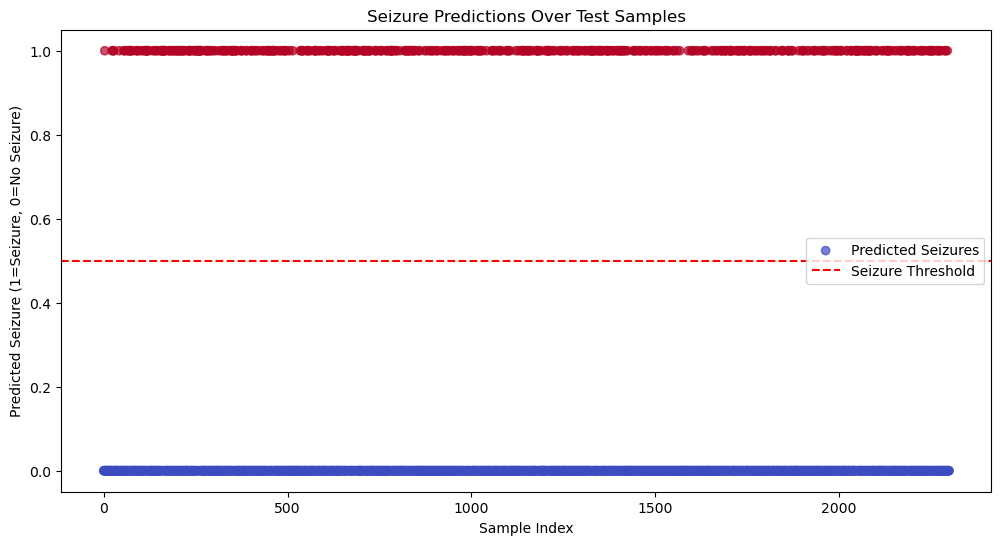

In [144]:
import matplotlib.pyplot as plt

# Convert Prediction column to binary (1 for Seizure, 0 for No Seizure)
results_df['Predicted_Label'] = (results_df['Prediction'] == 'Seizure').astype(int)

plt.figure(figsize=(12, 6))
plt.scatter(
    results_df['Sample_ID'],
    results_df['Predicted_Label'],
    c=results_df['Predicted_Label'],
    cmap='coolwarm',
    alpha=0.7,
    label='Predicted Seizures'
)
plt.axhline(0.5, color='red', linestyle='--', label='Seizure Threshold')
plt.title('Seizure Predictions Over Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Seizure (1=Seizure, 0=No Seizure)')
plt.legend()

# Save the plot first
plt.savefig("seizure_predictions_over_time.png", dpi=300, bbox_inches='tight')

# Then show it
plt.show()


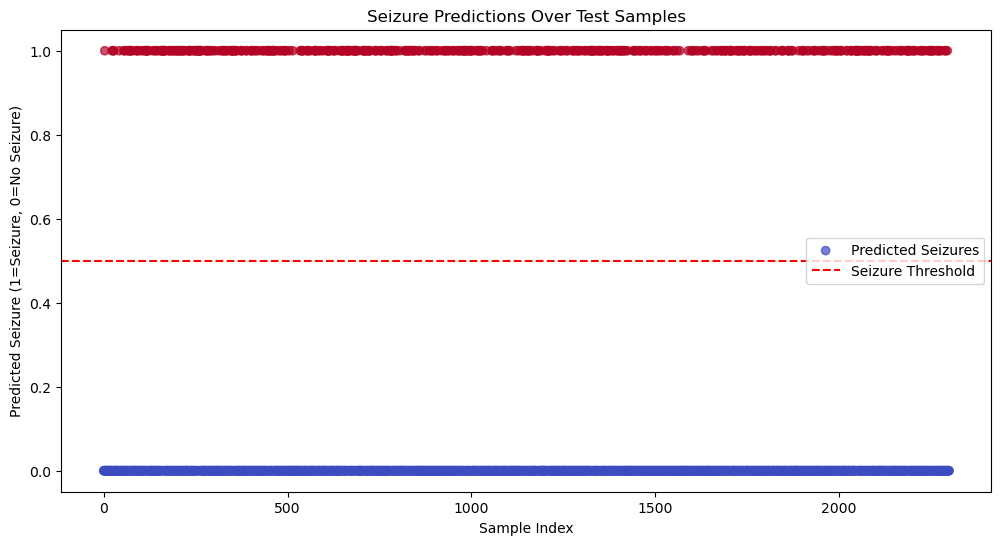

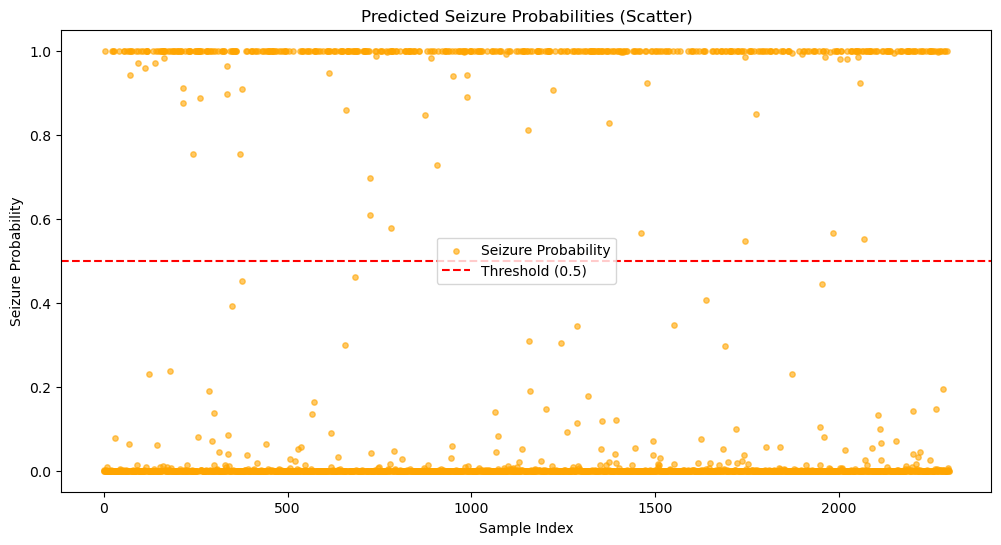

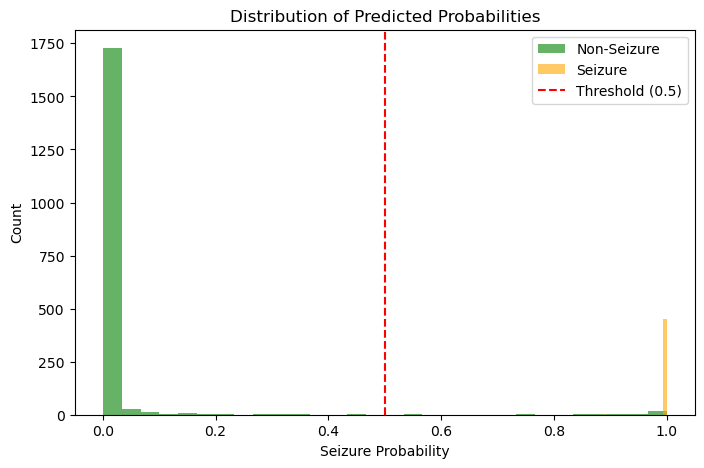

In [145]:
# ================================================
# 📊 Visualization of Seizure Detection Results
# ================================================

import matplotlib.pyplot as plt

# Convert Prediction column to binary (1 for Seizure, 0 for No Seizure)
results_df['Predicted_Label'] = (results_df['Prediction'] == 'Seizure').astype(int)

# 1️⃣ Scatter Plot: Predicted Labels
plt.figure(figsize=(12, 6))
plt.scatter(
    results_df['Sample_ID'], 
    results_df['Predicted_Label'], 
    c=results_df['Predicted_Label'], 
    cmap='coolwarm', 
    alpha=0.7, 
    label='Predicted Seizures'
)
plt.axhline(0.5, color='red', linestyle='--', label='Seizure Threshold')
plt.title('Seizure Predictions Over Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Seizure (1=Seizure, 0=No Seizure)')
plt.legend()
plt.show()

# 2️⃣ Scatter Plot: Predicted Probabilities
plt.figure(figsize=(12, 6))
plt.scatter(
    results_df['Sample_ID'], 
    results_df['Seizure_Prob'], 
    color='orange', 
    alpha=0.6, 
    s=15, 
    label='Seizure Probability'
)
plt.axhline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Predicted Seizure Probabilities (Scatter)')
plt.xlabel('Sample Index')
plt.ylabel('Seizure Probability')
plt.legend()
plt.show()

# 3️⃣ Histogram: Probability Distribution by Ground Truth
plt.figure(figsize=(8, 5))
plt.hist(
    results_df.loc[results_df['Ground_Truth']=='No Seizure', 'Seizure_Prob'], 
    bins=30, alpha=0.6, label='Non-Seizure', color='green'
)
plt.hist(
    results_df.loc[results_df['Ground_Truth']=='Seizure', 'Seizure_Prob'], 
    bins=30, alpha=0.6, label='Seizure', color='orange'
)
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Seizure Probability')
plt.ylabel('Count')
plt.legend()
plt.show()


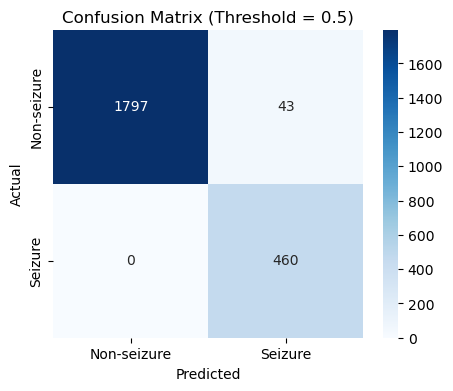

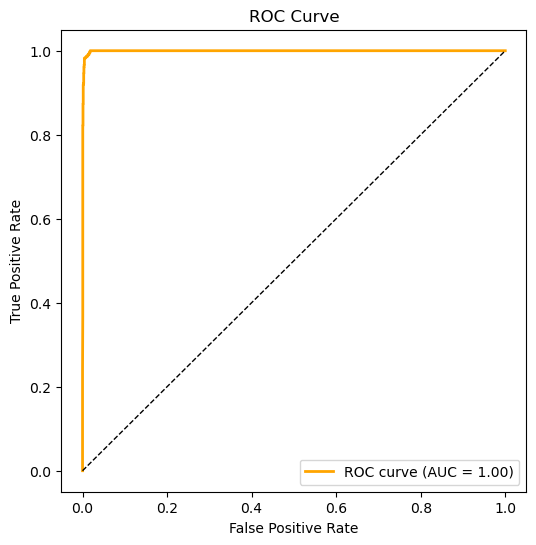

Threshold | Accuracy | Precision | Recall | F1-Score
--------------------------------------------------
     0.1 | 0.9683  | 0.8630   | 1.0000 | 0.9265
     0.2 | 0.9752  | 0.8897   | 1.0000 | 0.9417
     0.3 | 0.9774  | 0.8984   | 1.0000 | 0.9465
     0.4 | 0.9796  | 0.9073   | 1.0000 | 0.9514
     0.5 | 0.9813  | 0.9145   | 1.0000 | 0.9553
     0.6 | 0.9835  | 0.9237   | 1.0000 | 0.9603
     0.7 | 0.9843  | 0.9274   | 1.0000 | 0.9623


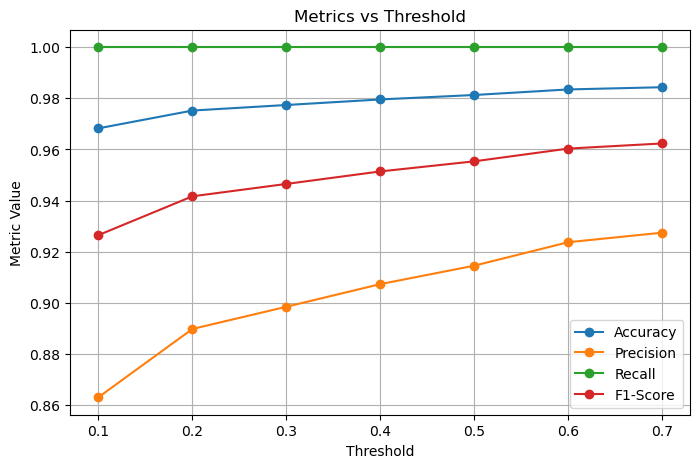

In [146]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Binary arrays for evaluation
# ----------------------------
y_true = (results_df['Ground_Truth'] == 'Seizure').astype(int).values
y_prob = results_df['Seizure_Prob'].values

# ----------------------------
# 1️⃣ Confusion Matrix at default threshold 0.5
# ----------------------------
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-seizure','Seizure'],
            yticklabels=['Non-seizure','Seizure'])
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ----------------------------
# 2️⃣ ROC Curve & AUC
# ----------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='orange', linewidth=2)
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# ----------------------------
# 3️⃣ Evaluate multiple thresholds
# ----------------------------
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
print("Threshold | Accuracy | Precision | Recall | F1-Score")
print("-"*50)

for thresh in thresholds_to_test:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_true, y_pred_thresh)
    prec = precision_score(y_true, y_pred_thresh, zero_division=0)
    rec = recall_score(y_true, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
    
    print(f"{thresh:>8} | {acc:.4f}  | {prec:.4f}   | {rec:.4f} | {f1:.4f}")

# Optional: Plot metrics vs thresholds
metrics_acc = [accuracy_score(y_true, (y_prob >= t).astype(int)) for t in thresholds_to_test]
metrics_prec = [precision_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in thresholds_to_test]
metrics_rec = [recall_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in thresholds_to_test]
metrics_f1 = [f1_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in thresholds_to_test]

plt.figure(figsize=(8,5))
plt.plot(thresholds_to_test, metrics_acc, marker='o', label='Accuracy')
plt.plot(thresholds_to_test, metrics_prec, marker='o', label='Precision')
plt.plot(thresholds_to_test, metrics_rec, marker='o', label='Recall')
plt.plot(thresholds_to_test, metrics_f1, marker='o', label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [147]:
import tensorflow as tf
import joblib
import numpy as np

# ----------------------------
# Load model and scaler once
# ----------------------------
model = tf.keras.models.load_model(r"D:\epileptic project\seizure_detection_model.keras", compile=False)
scaler = joblib.load(r"D:\epileptic project\scaler.save")
timesteps = 178  # number of features in EEG vector

# ----------------------------
# Prediction Function
# ----------------------------
def predict_seizure(sample_vector, threshold=0.2):
    """
    Predicts seizure probability and class for a 1D EEG vector.

    Args:
        sample_vector (np.array): 1D EEG vector of length `timesteps`.
        threshold (float): Probability threshold to classify as seizure.

    Returns:
        predicted_class (int): 1=Seizure, 0=No Seizure
        seizure_prob (float): Model-predicted probability of seizure
    """
    # Scale and reshape
    sample_scaled = scaler.transform(sample_vector.reshape(1, -1))
    sample_reshaped = sample_scaled.reshape(1, timesteps, 1)

    # Predict probability
    seizure_prob = model.predict(sample_reshaped, verbose=0)[0][1]

    # Apply threshold for class
    predicted_class = 1 if seizure_prob > threshold else 0

    return predicted_class, seizure_prob

# ----------------------------
# Example Usage (Corrected)
# ----------------------------

# Find the index of the first real seizure sample in the test set
seizure_sample_index = np.where(y_test == 1)[0][0]
real_seizure_data = X_test_orig[seizure_sample_index]

# Predict on the real seizure sample
pred_class, prob = predict_seizure(real_seizure_data)

print(f"Testing on a real seizure sample (Index: {seizure_sample_index})")
print(f"Seizure Probability: {prob:.6f}")
print(f"Predicted Class: {pred_class} ({'Seizure' if pred_class==1 else 'No Seizure'})")


Testing on a real seizure sample (Index: 3)
Seizure Probability: 1.000000
Predicted Class: 1 (Seizure)



📌 Prediction Results on Test Data:


,Sample_ID,Ground_Truth,Prediction,Seizure_Prob,Predicted_Label
0,0,No Seizure,No Seizure,9.225459e-06,0
1,1,No Seizure,No Seizure,5.705201e-04,0
2,2,No Seizure,No Seizure,3.566680e-07,0
3,3,Seizure,Seizure,9.999995e-01,1
4,4,No Seizure,No Seizure,1.871900e-06,0
5,5,No Seizure,No Seizure,3.352239e-06,0
6,6,No Seizure,No Seizure,1.503659e-03,0
7,7,No Seizure,No Seizure,1.239533e-06,0
8,8,No Seizure,No Seizure,8.992734e-03,0
9,9,No Seizure,No Seizure,3.758544e-08,0


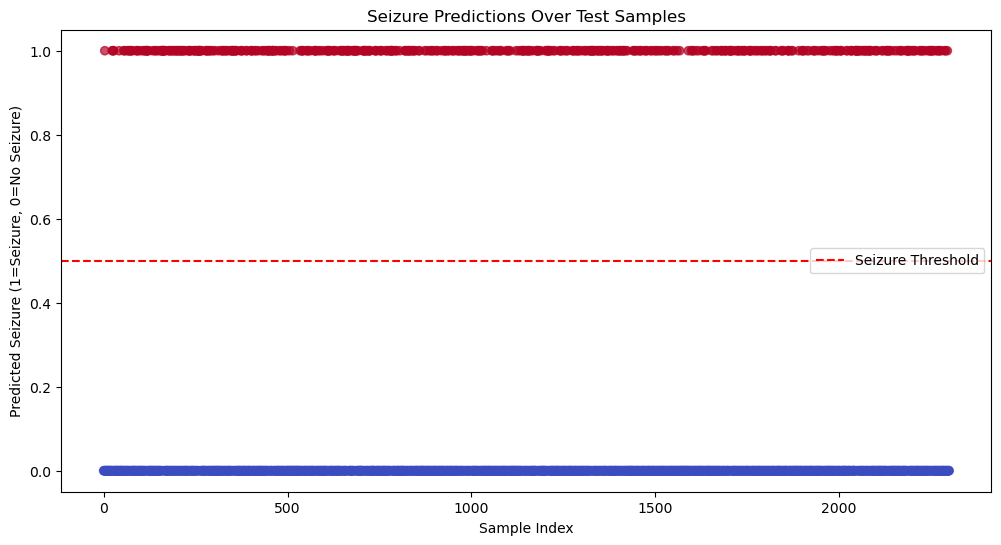

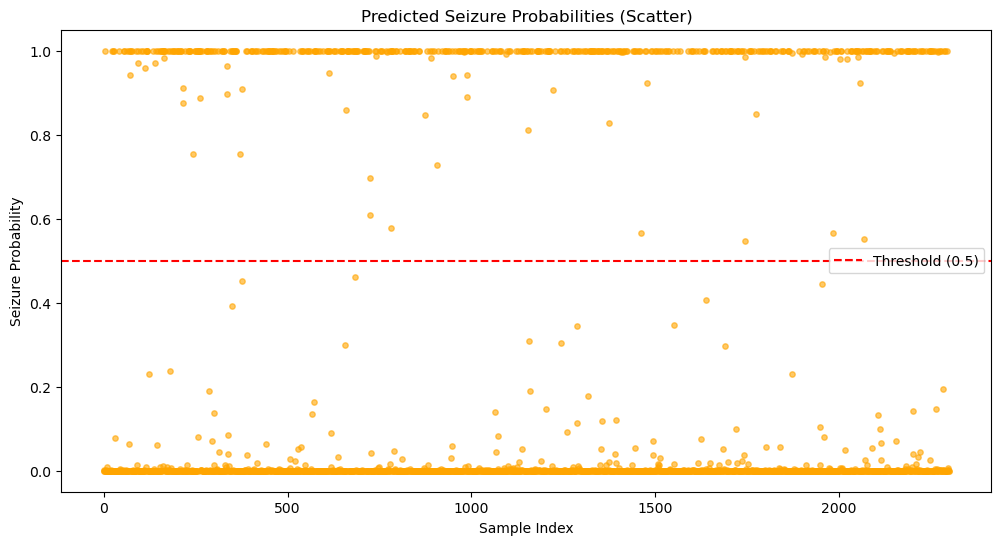

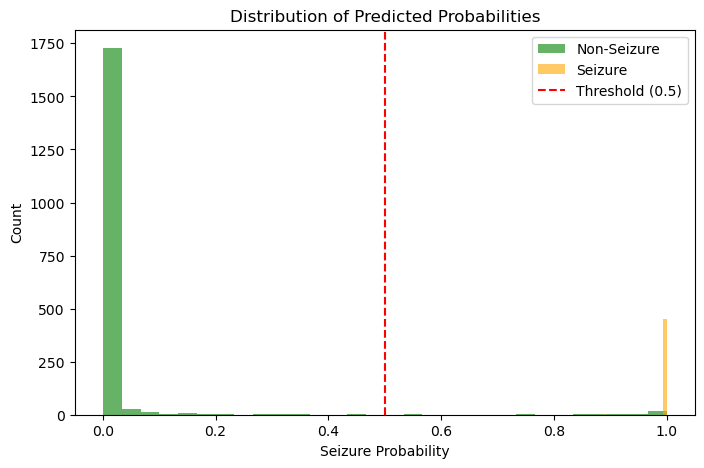

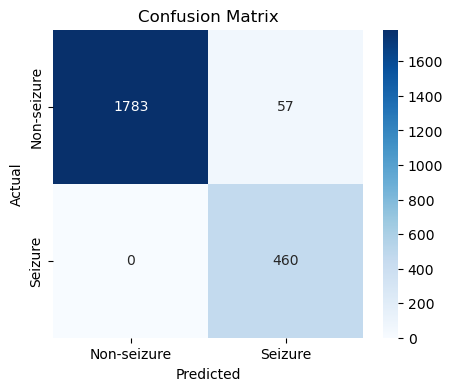

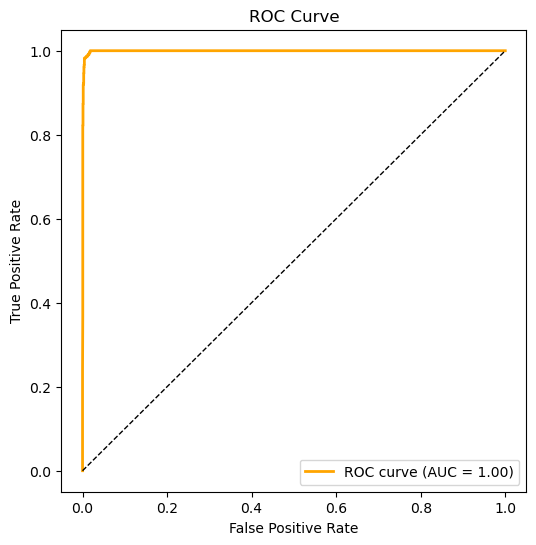

In [148]:
# =========================================
# 📊 Create a Results Table for Predictions
# =========================================

import pandas as pd

results = []

# Use original raw features from the dataset
X_test_raw = X_test_orig = scaler.inverse_transform(X_test.reshape(-1, timesteps))  # unscale X_test

for i in range(len(X_test_raw)):
    features = X_test_raw[i]  # raw unscaled features
    true_label = y_test[i]
    pred_label, seizure_prob = predict_seizure(features)  # scales internally
    
    results.append({
        "Sample_ID": i,
        "Ground_Truth": "Seizure" if true_label==1 else "No Seizure",
        "Prediction": "Seizure" if pred_label==1 else "No Seizure",
        "Seizure_Prob": seizure_prob
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Convert Prediction column to binary for plotting
results_df['Predicted_Label'] = (results_df['Prediction'] == 'Seizure').astype(int)

# Display first 20 rows
print("\n📌 Prediction Results on Test Data:")
display(results_df.head(20))

# =========================================
# 📈 Visualization of Seizure Detection Results
# =========================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1️⃣ Scatter Plot of Predicted Seizures
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Sample_ID'], results_df['Predicted_Label'], 
            c=results_df['Predicted_Label'], cmap='coolwarm', alpha=0.7)
plt.axhline(0.5, color='red', linestyle='--', label='Seizure Threshold')
plt.title('Seizure Predictions Over Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Seizure (1=Seizure, 0=No Seizure)')
plt.legend()
plt.show()

# 2️⃣ Scatter Plot of Seizure Probabilities
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Sample_ID'], results_df['Seizure_Prob'], color='orange', alpha=0.6, s=15)
plt.axhline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Predicted Seizure Probabilities (Scatter)')
plt.xlabel('Sample Index')
plt.ylabel('Seizure Probability')
plt.legend()
plt.show()

# 3️⃣ Histogram of Predicted Probabilities
plt.figure(figsize=(8, 5))
plt.hist(results_df.loc[results_df['Ground_Truth']=='No Seizure', 'Seizure_Prob'], bins=30, alpha=0.6, label='Non-Seizure', color='green')
plt.hist(results_df.loc[results_df['Ground_Truth']=='Seizure', 'Seizure_Prob'], bins=30, alpha=0.6, label='Seizure', color='orange')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Seizure Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

# =========================================
# 📊 Confusion Matrix & ROC Curve
# =========================================

# Binary arrays for evaluation
y_true = (results_df['Ground_Truth'] == 'Seizure').astype(int).values
y_pred = results_df['Predicted_Label'].values
y_prob = results_df['Seizure_Prob'].values

# 1️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-seizure','Seizure'],
            yticklabels=['Non-seizure','Seizure'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2️⃣ ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='orange', linewidth=2)
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [149]:
# =========================================
# 📌 10. Model Summary & Logging
# =========================================

import pandas as pd

# 1️⃣ Model Summary
print("\n================== Model Summary ==================")
model.summary()  # prints layers, output shapes, number of params

total_params = model.count_params()
print(f"\nTotal parameters: {total_params}\n")

# 2️⃣ Log training history to CSV
history_df = pd.DataFrame(history.history)
csv_path = r"D:\epileptic project\training_history.csv"
history_df.to_csv(csv_path, index=False)
print(f"✅ Training/Validation metrics saved to: {csv_path}")

# 3️⃣ Optional: Compare CNN+LSTM vs CNN+GRU
# Build GRU variant
gru_model = build_model(X_train.shape[1], model_variant='gru')
gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train GRU model (shorter epochs for quick comparison)
gru_history = gru_model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=10,
    batch_size=64,
    class_weight=class_weights,
    verbose=2
)

# Save GRU model 
gru_model.save(r"D:\epileptic project\seizure_detection_model_gru.keras")




================== Model Summary ==================


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 178, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 178, 64)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 178, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 89, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 89, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 44, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 44, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 44, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 44, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,658 (1.86 MB)

 Trainable params: 486,274 (1.85 MB)

 Non-trainable params: 384 (1.50 KB)


Total parameters: 486658

✅ Training/Validation metrics saved to: D:\epileptic project\training_history.csv
Epoch 1/10
196/196 - 24s - 123ms/step - accuracy: 0.9166 - loss: 0.2031 - val_accuracy: 0.3723 - val_loss: 2.8600
Epoch 2/10
196/196 - 7s - 34ms/step - accuracy: 0.9566 - loss: 0.1196 - val_accuracy: 0.7283 - val_loss: 1.0947
Epoch 3/10
196/196 - 10s - 53ms/step - accuracy: 0.9661 - loss: 0.0925 - val_accuracy: 0.8945 - val_loss: 0.3328
Epoch 4/10
196/196 - 7s - 33ms/step - accuracy: 0.9735 - loss: 0.0713 - val_accuracy: 0.9552 - val_loss: 0.1343
Epoch 5/10
196/196 - 6s - 33ms/step - accuracy: 0.9810 - loss: 0.0558 - val_accuracy: 0.9153 - val_loss: 0.3866
Epoch 6/10
196/196 - 6s - 33ms/step - accuracy: 0.9801 - loss: 0.0570 - val_accuracy: 0.9611 - val_loss: 0.0982
Epoch 7/10
196/196 - 6s - 32ms/step - accuracy: 0.9828 - loss: 0.0465 - val_accuracy: 0.9638 - val_loss: 0.1268
Epoch 8/10
196/196 - 6s - 33ms/step - accuracy: 0.9869 - loss: 0.0391 - val_accuracy: 0.9108 - val_loss:

✅ Model comparison CSV saved to: D:\epileptic project\model_comparison.csv


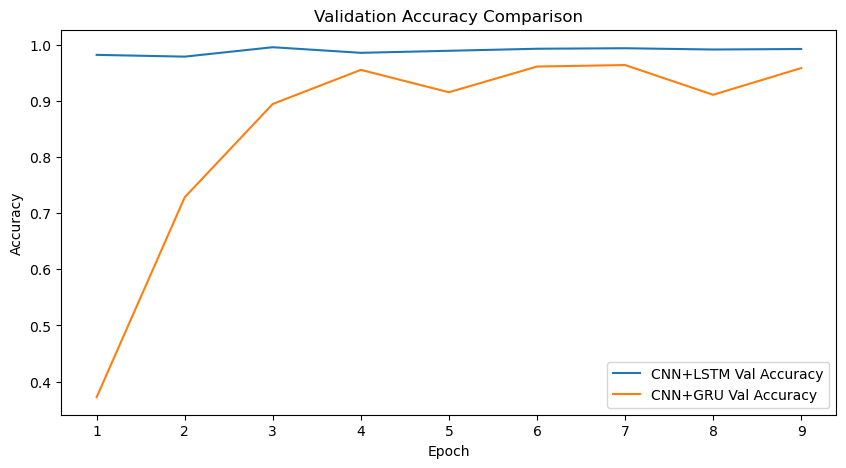

In [150]:
# Find minimum number of epochs between the two histories
min_epochs = min(len(history.history['accuracy']), len(gru_history.history['accuracy']))

comparison_df = pd.DataFrame({
    "Epoch": list(range(1, min_epochs + 1)),
    "CNN+LSTM_Accuracy": history.history['accuracy'][:min_epochs],
    "CNN+LSTM_Val_Accuracy": history.history['val_accuracy'][:min_epochs],
    "CNN+GRU_Accuracy": gru_history.history['accuracy'][:min_epochs],
    "CNN+GRU_Val_Accuracy": gru_history.history['val_accuracy'][:min_epochs]
})

comparison_csv_path = r"D:\epileptic project\model_comparison.csv"
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"✅ Model comparison CSV saved to: {comparison_csv_path}")

# Quick visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(comparison_df['Epoch'], comparison_df['CNN+LSTM_Val_Accuracy'], label='CNN+LSTM Val Accuracy')
plt.plot(comparison_df['Epoch'], comparison_df['CNN+GRU_Val_Accuracy'], label='CNN+GRU Val Accuracy')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [151]:
# Show test samples with highest predicted seizure probability
top_high_prob = results_df.sort_values('Seizure_Prob', ascending=False).head(10)
print("Top 10 test samples with highest predicted seizure probability:")
display(top_high_prob)


Top 10 test samples with highest predicted seizure probability:


,Sample_ID,Ground_Truth,Prediction,Seizure_Prob,Predicted_Label
1150,1150,Seizure,Seizure,1.0,1
1354,1354,Seizure,Seizure,1.0,1
2205,2205,Seizure,Seizure,1.0,1
1388,1388,Seizure,Seizure,1.0,1
1701,1701,Seizure,Seizure,1.0,1
584,584,Seizure,Seizure,1.0,1
1371,1371,Seizure,Seizure,1.0,1
2083,2083,Seizure,Seizure,1.0,1
211,211,Seizure,Seizure,1.0,1
886,886,Seizure,Seizure,1.0,1


In [152]:
# --- Final, Robust Sanity Check ---

import tensorflow as tf
import joblib
import numpy as np

print("--- Running Final Sanity Check ---")

# 1. Load the primary saved model and scaler
model_path = r"D:\epileptic project\seizure_detection_model.keras"
scaler_path = r"D:\epileptic project\scaler.save"
loaded_model = tf.keras.models.load_model(model_path)
loaded_scaler = joblib.load(scaler_path)
print("✅ Artifacts loaded successfully.")

# 2. Find the index of a real seizure sample from the original test set
seizure_indices = np.where(y_test == 1)[0]
if len(seizure_indices) > 0:
    test_index = seizure_indices[0] # Use the first available seizure sample
    seizure_features = X_test_orig[test_index].reshape(1, -1)

    # 3. Apply the prediction pipeline
    scaled_features = loaded_scaler.transform(seizure_features)
    reshaped_features = scaled_features.reshape(1, 178, 1)
    prediction_prob = loaded_model.predict(reshaped_features)[0][1]

    print(f"\nTesting on a real seizure sample (Index: {test_index})")
    print(f"RAW SEIZURE PROBABILITY IN NOTEBOOK: {prediction_prob:.6f}")

    if prediction_prob > 0.5:
        print("✅ SUCCESS: The model correctly predicts a seizure in the notebook.")
    else:
        print("❌ FAILURE: The model does NOT predict a seizure in the notebook.")
else:
    print("Warning: No seizure samples found in the test set to run the sanity check.")

--- Running Final Sanity Check ---
✅ Artifacts loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Testing on a real seizure sample (Index: 3)
RAW SEIZURE PROBABILITY IN NOTEBOOK: 1.000000
✅ SUCCESS: The model correctly predicts a seizure in the notebook.


Plots will be saved to: D:\epileptic project\plots
Saving training history plot...


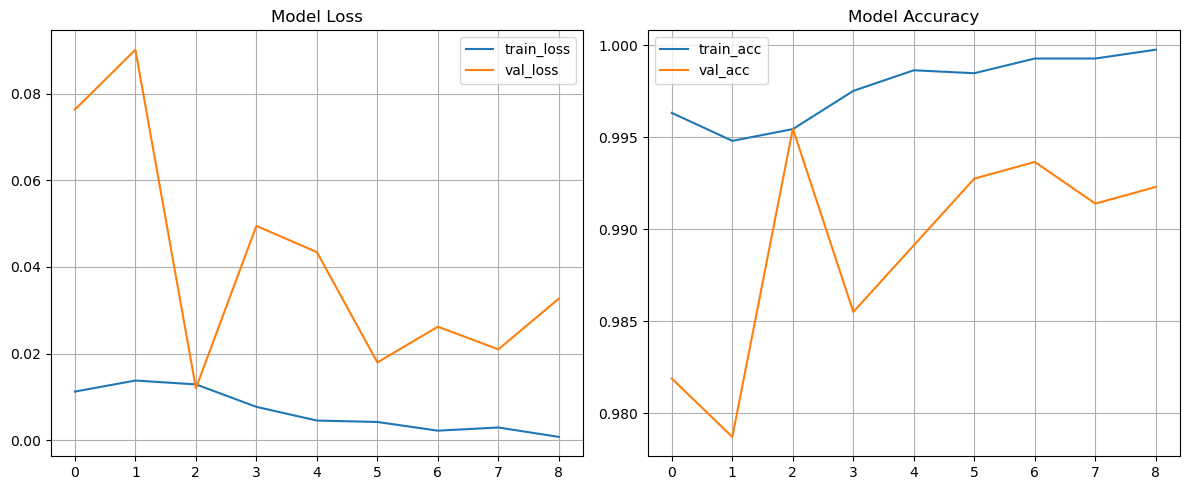

Saving confusion matrix plot...


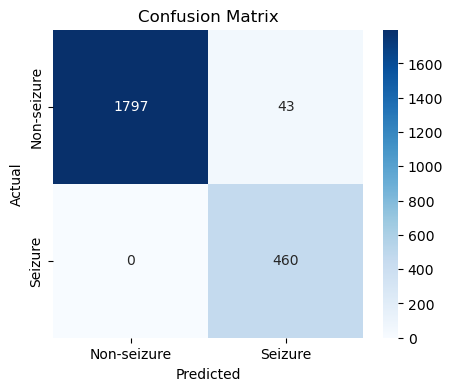

Saving normalized confusion matrix plot...


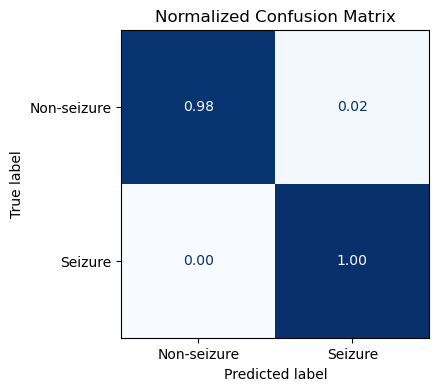

Saving seizure probabilities scatter plot...


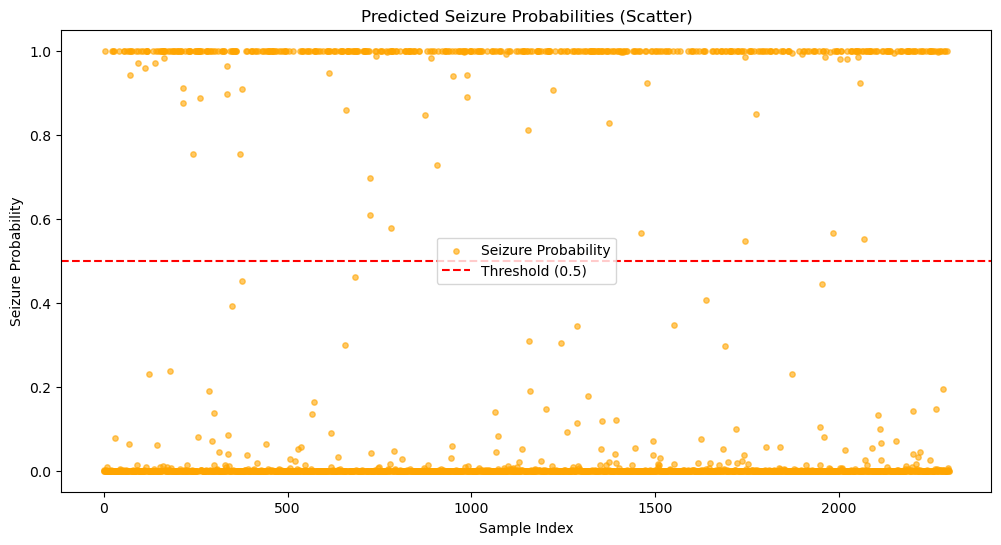

Saving probability distribution histogram...


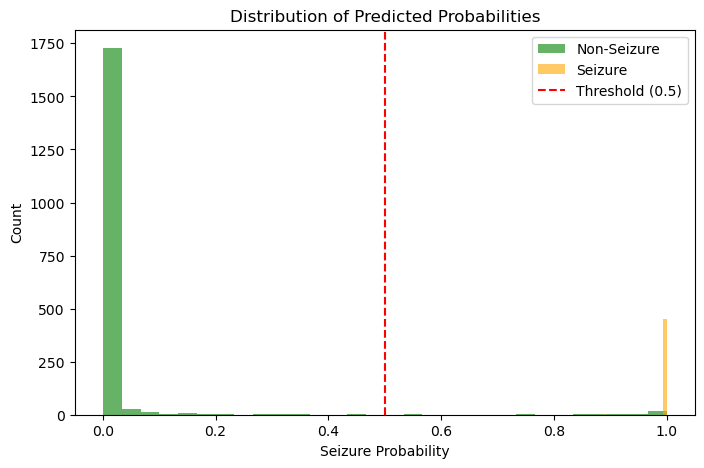

Saving ROC curve plot...


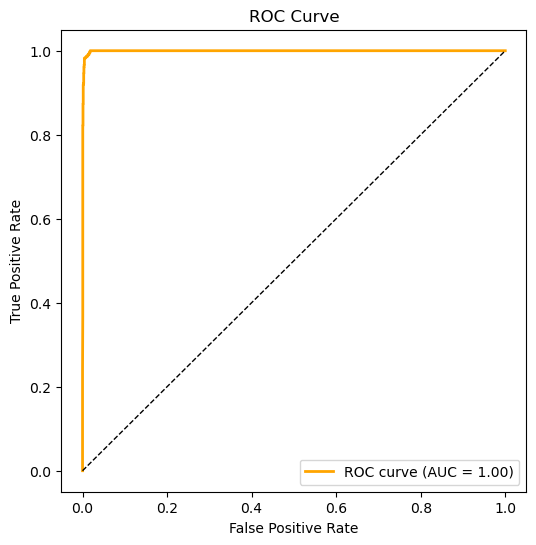


✅ All plots have been saved successfully!


In [153]:
# ================================================
# 💾 11. Save All Generated Plots to Files
# ================================================

import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# --- Create a folder to save the plots ---
plots_folder_path = r"D:\epileptic project\plots"
os.makedirs(plots_folder_path, exist_ok=True)
print(f"Plots will be saved to: {plots_folder_path}")

# --- 1. Training History Plot ---
print("Saving training history plot...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots_folder_path, "training_history.png"))
plt.show()

# --- 2. Confusion Matrix Plot ---
print("Saving confusion matrix plot...")
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-seizure', 'Seizure'],
            yticklabels=['Non-seizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(plots_folder_path, "confusion_matrix.png"))
plt.show()

# --- 3. Normalized Confusion Matrix Plot ---
print("Saving normalized confusion matrix plot...")
cm_norm = confusion_matrix(y_test, test_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Non-seizure', 'Seizure'])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized Confusion Matrix")
plt.savefig(os.path.join(plots_folder_path, "normalized_confusion_matrix.png"))
plt.show()

# --- 4. Scatter Plot of Predicted Probabilities ---
print("Saving seizure probabilities scatter plot...")
plt.figure(figsize=(12, 6))
plt.scatter(
    results_df['Sample_ID'],
    results_df['Seizure_Prob'],
    color='orange',
    alpha=0.6,
    s=15,
    label='Seizure Probability'
)
plt.axhline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Predicted Seizure Probabilities (Scatter)')
plt.xlabel('Sample Index')
plt.ylabel('Seizure Probability')
plt.legend()
plt.savefig(os.path.join(plots_folder_path, "seizure_probabilities_scatter.png"))
plt.show()

# --- 5. Histogram of Probability Distribution ---
print("Saving probability distribution histogram...")
plt.figure(figsize=(8, 5))
plt.hist(
    results_df.loc[results_df['Ground_Truth'] == 'No Seizure', 'Seizure_Prob'],
    bins=30, alpha=0.6, label='Non-Seizure', color='green'
)
plt.hist(
    results_df.loc[results_df['Ground_Truth'] == 'Seizure', 'Seizure_Prob'],
    bins=30, alpha=0.6, label='Seizure', color='orange'
)
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Seizure Probability')
plt.ylabel('Count')
plt.legend()
plt.savefig(os.path.join(plots_folder_path, "probability_distribution_histogram.png"))
plt.show()

# --- 6. ROC Curve Plot ---
print("Saving ROC curve plot...")
y_true = (results_df['Ground_Truth'] == 'Seizure').astype(int).values
y_prob = results_df['Seizure_Prob'].values
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='orange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(plots_folder_path, "roc_curve.png"))
plt.show()

print("\n✅ All plots have been saved successfully!")